In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

import os
import ctypes

In [2]:
dirname = '../src/model_ctypes/ina/'
filename_so = os.path.join(dirname, 'ina.so')

filename_so_abs = os.path.abspath(filename_so)

ina = ctypes.CDLL(filename_so_abs)

In [3]:
# void initialize_states_default(double *STATES)
ina.initialize_states_default.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
]
ina.initialize_states_default.restype = ctypes.c_void_p


# void compute_rates(const double time,  double *STATES, double *CONSTANTS,  double *ALGEBRAIC, double *RATES)
ina.compute_rates.argtypes = [
    ctypes.c_double,
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
]
ina.compute_rates.restype = ctypes.c_void_p


# void compute_algebraic(const double time,  double *STATES, double *CONSTANTS,  double *ALGEBRAIC)
ina.compute_algebraic.argtypes = [
    ctypes.c_double,
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS')
]
ina.compute_algebraic.restype = ctypes.c_void_p


# int run(double *S, double *C,
#         double *time_array, double *voltage_command_array, int array_length,
#         double *output_S, double *output_A)
ina.run.argtypes = [
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'), 
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'), 
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=1, flags='C_CONTIGUOUS'),
    ctypes.c_int,
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=2, flags='C_CONTIGUOUS'),
    np.ctypeslib.ndpointer(dtype=np.float64, ndim=2, flags='C_CONTIGUOUS')
]
ina.run.restype = ctypes.c_int

legend_constants = pd.read_csv(os.path.join(dirname, "legend_constants.csv"), index_col='name')['value']
legend_states = pd.read_csv(os.path.join(dirname, "legend_states.csv"), index_col='name')['value']
legend_algebraic = pd.read_csv(os.path.join(dirname, "legend_algebraic.csv"), index_col='name')['value']

In [4]:
S = legend_states.copy()
R = S.copy() * 0
C = legend_constants.copy()
A = legend_algebraic.copy()

In [5]:
# ina.initialize_states_default(S.values)
# S

In [6]:
# ina.compute_rates(0, S.values, C.values, A.values, R.values)
# R

In [7]:
# ina.compute_algebraic(0, S.values, C.values, A.values)
# A

In [8]:
# t = np.arange(0, 1e-3, 5e-5)
# v_c = np.full_like(t, -80.0)

# df_protocol = pd.DataFrame(np.vstack([t, v_c]).T, columns=['t', 'v_c'])

In [9]:
filename_protocol = "../data/protocols/protocol.csv"
df_protocol = pd.read_csv(filename_protocol)

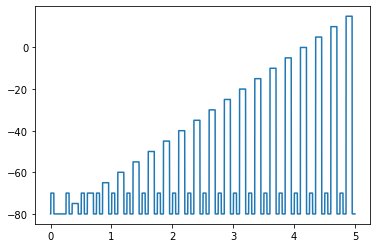

In [10]:
plt.plot(df_protocol.t, df_protocol.v)

In [11]:
output_len = len(df_protocol)

output_S = pd.DataFrame(np.zeros((output_len, len(S))), columns=legend_states.index)
output_A = pd.DataFrame(np.zeros((output_len, len(A))), columns=legend_algebraic.index)

In [12]:
%%time
status = ina.run(S.values.copy(), C.values.copy(),
        df_protocol['t'].values, df_protocol['v'].values, output_len,
        output_S.values, output_A.values)
status

CPU times: user 26.7 ms, sys: 8.52 ms, total: 35.2 ms
Wall time: 34.4 ms


2

In [13]:
output_S

name,v_comp,v_p,v_m,m,h,j,I_out
0,-80.0,-80.0,-80.000000,0.000000,1.000000,1.000000,0.000000
1,-80.0,-80.0,-79.942683,0.000009,0.999975,0.998474,-3.991031
2,-80.0,-80.0,-79.885883,0.000016,0.999950,0.997028,-6.502548
3,-80.0,-80.0,-79.829597,0.000022,0.999925,0.995656,-8.114783
4,-80.0,-80.0,-79.773820,0.000028,0.999900,0.994354,-9.181532
...,...,...,...,...,...,...,...
99995,-80.0,-80.0,-73.483189,0.000172,0.302952,0.924066,-36.157096
99996,-80.0,-80.0,-73.484767,0.000172,0.303484,0.924090,-36.150656
99997,-80.0,-80.0,-73.486330,0.000172,0.304015,0.924113,-36.144275
99998,-80.0,-80.0,-73.487878,0.000172,0.304546,0.924136,-36.137952


In [14]:
output_A

name,tau_m,tau_h,tau_j,m_inf,h_inf,v_cp,I_leak,I_Na,I_c,I_p,I_comp,I_in
0,0.000289,0.049458,0.000779,0.000054,0.975572,-80.0,-38.499544,-0.000000e+00,28.478207,0.000000,0.000000,-10.021337
1,0.000290,0.049567,0.000779,0.000055,0.975264,-80.0,-38.465464,-5.007076e-08,28.160256,0.000000,0.000000,-10.305208
2,0.000291,0.049666,0.000779,0.000056,0.974980,-80.0,-38.434434,-2.716221e-07,27.870759,0.000000,0.000000,-10.563675
3,0.000292,0.049763,0.000779,0.000056,0.974696,-80.0,-38.403723,-6.812132e-07,27.584239,0.000000,0.000000,-10.819484
4,0.000293,0.049840,0.000779,0.000057,0.974471,-80.0,-38.379658,-1.112499e-06,27.359725,0.000000,0.000000,-11.019934
...,...,...,...,...,...,...,...,...,...,...,...,...
99995,0.000396,0.058401,0.000779,0.000171,0.924706,-80.0,-35.373884,-5.839674e-05,-0.682648,0.000009,-0.000002,-36.056589
99996,0.000396,0.058401,0.000779,0.000171,0.924706,-80.0,-35.373884,-5.839674e-05,-0.682648,0.000009,-0.000002,-36.056589
99997,0.000396,0.058401,0.000779,0.000171,0.924706,-80.0,-35.373884,-5.839674e-05,-0.682648,0.000009,-0.000002,-36.056589
99998,0.000396,0.058401,0.000779,0.000171,0.924706,-80.0,-35.373884,-5.839674e-05,-0.682648,0.000009,-0.000002,-36.056589


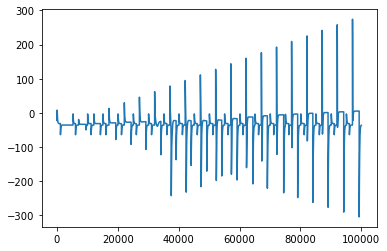

In [15]:
plt.plot(output_S.I_out)

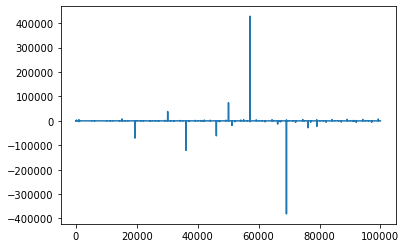

In [16]:
plt.plot(output_A.I_p)